In [1]:
from pymongo import MongoClient
import altair as alt
import pandas as pd

In [2]:
client = MongoClient()
db = client['geo_data']
col = db['geo_records']

In [85]:
pipeline = [
    {
        "$geoNear": {
            "near": [1.575, 7.5],
            "distanceField": "range",
            "key": "location",
            "num": 10001,
        }
    },
    {
        "$addFields": {
            "zone": {
                "$switch": {
                    "branches": [
                        {"case": {"$lte": ["$range", 1.25]}, "then": "inner"},
                        {"case": {"$lte": ["$range", 2.45]}, "then": "short"},
                        {"case": {"$lte": ["$range", 4.88]}, "then": "mid"},
                        {
                            "case": {
                                "$cond": {
                                    "if": {
                                        "$lte": [{"$arrayElemAt": ["$location", 0]}, 3]
                                    },
                                    "then": {
                                        "$and": [
                                            {
                                                "$gte": [
                                                    {"$arrayElemAt": ["$location", 1]},
                                                    0.9,
                                                ]
                                            },
                                            {
                                                "$lte": [
                                                    {"$arrayElemAt": ["$location", 1]},
                                                    14.1,
                                                ]
                                            },
                                        ]
                                    },
                                    "else": {"$lte": ["$range", 6.75]},
                                }
                            },
                            "then": "long",
                        },
                    ],
                    "default": "3PT",
                }
            }
        }
    },
    {
        "$addFields": {
            "info": {
                "$mergeObjects": [
                    {"zone": "$zone", "range": "$range"},
                    {"$arrayToObject": {"$zip": {"inputs": [["x", "y"], "$location"]}}},
                ]
            }
        }
    },
    {"$replaceRoot": {"newRoot": "$info"}},
]

In [108]:
data = list(col.aggregate(pipeline))

In [109]:
df = pd.DataFrame(data)

In [110]:
chart = alt.Chart(df).mark_point()

In [111]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

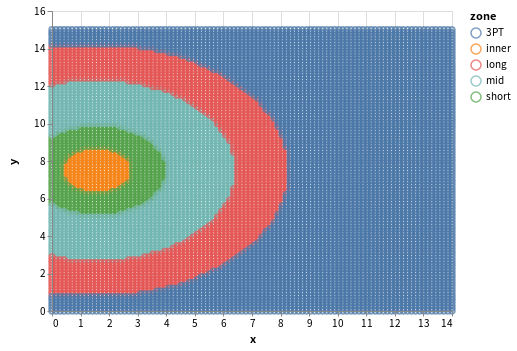

In [112]:
chart.encode(x = alt.X('x', scale=alt.Scale(domain=[0, 14])), y = alt.Y('y', scale=alt.Scale(domain=[0, 15.0])), color="zone")